# Mini Projekt 3
## Janek Filipecki, Wojtek Zarzecki
### Instrukcje
Tym razem zadanie polega na stworzeniu klasyfikatora obrazków działającego na 50 klasach z różnymi przedmiotami/zwierzętami itp. Do dyspozycji mają Państwo zbiór treningowy podzielony na odpowiednie podfoldery z klasami oraz zbiór testowy - bez podziału. Zbiór treningowy jest przygotowany w taki sposób by można go było łatwo załadować za pomocą klasy torchvision.ImageFolder wywołując np:
trainset = ImageFolder("data/train/", transform=train_transform)
Wówczas wszystkie przykłady zostaną przypisane do odpowiedniej klasy w zależności od tego w jakim podfolderze się znajdowały.
Jako że dane są bardzo duże to umieściłem je na OneDrive:
(train.zip i test_all.zip)

Proszę zwrócić szczególną uwagę na formę zwracanego rozwiązania, bo ostatnio większość z państwa zrobiła to byle jak i miałem bardzo dużo problemów z dodawaniem/usuwaniem niepotrzebnych wierszy itp. Tym razem nie będę poprawiał przesyłanych przez Państwa plików tylko wpisywał 0% accuracy!
W ramach rozwiązania, proszę oddać przez teamsy plik archiwum .zip z kodem (w formie notebooka, lub skryptu/skryptów .py) oraz plikiem .csv z predykcjami na zbiorze testowym. BEZ dodatkowych podfolderów i BEZ danych. W ramach predykcji proszę zapisać tym razem dwie kolumny (bez nagłówków):
Pierwszą kolumnę z nazwami plików testowych (uwaga pliki nazywają się np. 850043533599308.JPEG a nie 850043533599308.jpeg, 850043533599308.jpg czy 850043533599308). Proszę zwrócić na to uwagę bo mój skrypt ewaluacyjny inaczej nie zadziała.
Drugą kolumnę z wartościami oznaczającą predykcję numeru klasy. Klasy ponumerowane są zgodnie z numeracją ze zbioru treningowego (alfabetycznie startując od zera). Po utworzeniu datasetu w oparciu o ImageFolder klasy powinny się tak przypisać autoamtycznie - mogą to państwo sprawdzić wywołując trainset.classes.
Bardzo proszę nazywać wszystkie przesyłane pliki nazwiskami autorów (najlepiej alfabetycznie). Wyszukiwanie kto podpisał się "predictions.csv", a kto projekt_2.ipynb jest uciążliwe. Nazwę głównego archiwum zip, proszę dodatkowo rozpocząć od przedrostka poniedzialek_ lub piatek_, NIE pn,ptk albo coś w tym stylu.
Końcowe wyniki obliczał będę w oparciu o zwykłe accuracy (klasy są zbilansowane).
Uwaga: W zadaniu proszę nie wykorzystywać gotowych architektur o których wspominałem na zajęciach. Proszę też nie kopiować gotowych fragmentów (np. bloki resnetowe itp). Ostatnie laboratorium poświęcone będzie dokładnie temu zagadnieniu.

W MS Teams przydzieliłem zadanie wszystkim uczestnikom, ale bardzo proszę żeby tylko jeden (dowolny) członek zespołu je zwrócił (proszę się dogadać).
W razie pytań zapraszam do korespondencji lub na konsultacje.

### Importy

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from tqdm.notebook import tqdm

### Obsługa cuda

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Zaimportowanie datasetu oraz data augmentation

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.4),
     transforms.RandomRotation(20),
     transforms.ToTensor(),
     transforms.RandomErasing(0.3),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

BATCH_SIZE = 128

# from google.colab import files
# uploaded = files.upload()
raw_train_set = ImageFolder("data/train/", transform=transform)

In [4]:
raw_train_set.class_to_idx

{'acoustic': 0,
 'antenna': 1,
 'bacteria': 2,
 'battery': 3,
 'bean': 4,
 'beetle': 5,
 'bicycle': 6,
 'birch': 7,
 'bird': 8,
 'bomb': 9,
 'bread': 10,
 'bridge': 11,
 'camera': 12,
 'carbon': 13,
 'cat': 14,
 'corn': 15,
 'crab': 16,
 'crocodilian': 17,
 'echinoderm': 18,
 'egg': 19,
 'elephant': 20,
 'fish': 21,
 'flower': 22,
 'frog': 23,
 'fungus': 24,
 'gauge': 25,
 'hammer': 26,
 'icecream': 27,
 'kangaroo': 28,
 'memorial': 29,
 'monkey': 30,
 'motor': 31,
 'nest': 32,
 'palm': 33,
 'pizza': 34,
 'pot': 35,
 'printer': 36,
 'saw': 37,
 'snake': 38,
 'spice': 39,
 'spider': 40,
 'spoon': 41,
 'squash': 42,
 'swine': 43,
 'tea': 44,
 'tomato': 45,
 'towel': 46,
 'truck': 47,
 'turtle': 48,
 'worm': 49}

### Obsługa i analiza datasetu

#### Train-test split

In [5]:
def split_dataset(dataset, test_size, random_state):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=random_state)
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

In [6]:
train_data, test_data = split_dataset(raw_train_set, 0.2, 42)

#### Dataloadery

In [7]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 

In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

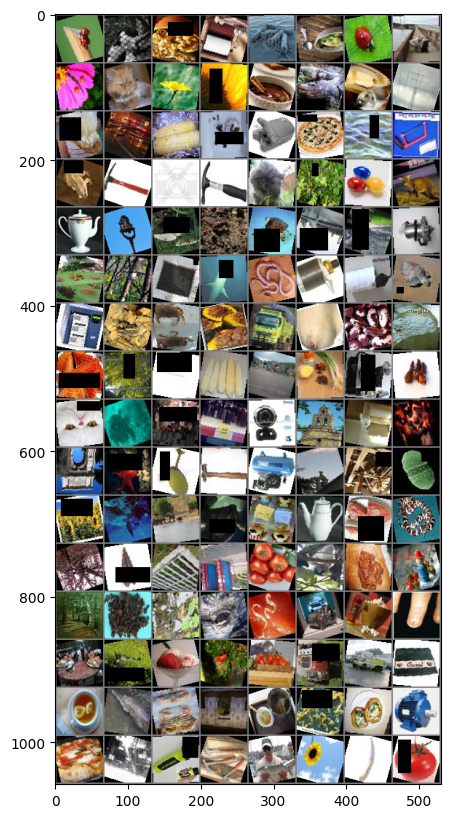

beetle monkey  corn towel bacteria spoon beetle bridge beetle   cat flower flower spice crocodilian icecream antenna icecream truck  corn spice antenna pizza turtle   saw  frog hammer spoon hammer   cat tomato   egg kangaroo   pot acoustic fungus beetle turtle bridge crocodilian motor spice  bird memorial  fish snake motor towel turtle printer beetle  crab squash truck bacteria  bean crocodilian echinoderm birch  crab  corn truck spice camera spice   cat turtle towel battery camera acoustic   cat carbon memorial echinoderm antenna hammer motor acoustic acoustic bacteria flower turtle elephant turtle towel   pot pizza snake acoustic towel bridge bridge tomato monkey bacteria tomato birch spice  frog crocodilian  worm motor  corn bacteria  crab crocodilian icecream  frog tomato truck truck towel   tea crocodilian  crab memorial   tea bacteria squash motor pizza bridge battery hammer  fish flower   saw tomato


In [10]:
plt.figure(figsize = (20,10))
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % raw_train_set.classes[labels[j]] for j in range(BATCH_SIZE)))

In [11]:
def peek_class(class_name, dataset, img_num):
    cls_idx = raw_train_set.class_to_idx[class_name]
    data_indexes = [idx for idx, img_idx_tuple in enumerate(dataset.imgs) if img_idx_tuple[1] == cls_idx]
    class_set = Subset(dataset, data_indexes)
    class_loader = DataLoader(class_set, batch_size=img_num,
                              shuffle=True, num_workers=2)
    images, labels = next(iter(class_loader))
    plt.figure(figsize=(20,10))
    imshow(torchvision.utils.make_grid(images))
    print(' '.join('%5s' % raw_train_set.classes[labels[j]] for j in range(img_num)))

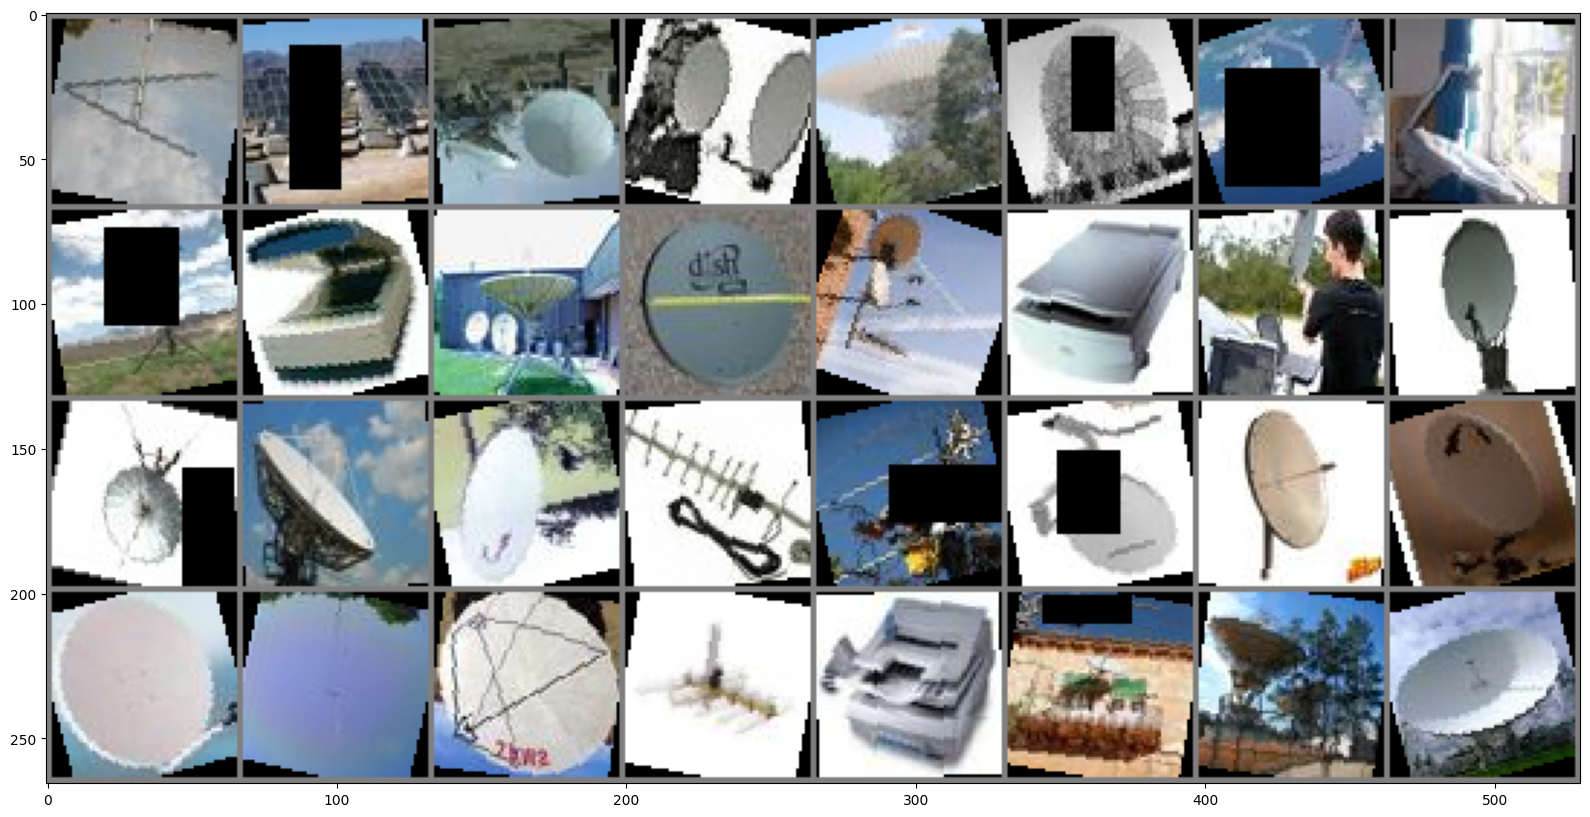

antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna


In [12]:
peek_class("antenna", raw_train_set, 32)

### Sprawdzenie rozmiaru obrazu

In [12]:
images[0:1].size()

torch.Size([1, 3, 64, 64])

#### Na pierwszy rzut oka widać że niektóre przykłady nie mają sensu nawet dla człowieka, więc może się zdarzyc tak, że trening że część przykładów nie będzie się dawała dotrenować.

### Pętla treningowa

In [ ]:
import os


def train(model, optimizer, criterion, epoch_num, train_loader, test_loader, dir_path="weights", model_name="model"):
    train_batch_num, test_batch_num = len(train_loader), len(test_loader)

    best_accuracy = 0

    train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = [], [], [], []
    for epoch in range(1, epoch_num + 1): 
        print(f"[{epoch + 1}/{epoch_num}]")
        # train
        model.train()

        # train_progress_bar = tqdm(total=train_batch_num)
        batch_loss, batch_accuracy, batch_correct_sum, train_running_loss_sum, train_running_loss, train_running_accuracy, train_correct_sum, train_sample_sum = 0, 0, 0, 0, 0, 0, 0, 0
        epoch_loss, epoch_accuracy = 0, 0
        for batch_num, data in enumerate(train_loader, 1):
            inputs, labels = data
            train_sample_sum += len(inputs)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            train_running_loss_sum += batch_loss
            train_running_loss = train_running_loss_sum/batch_num
            epoch_loss += batch_loss


            _, predicted = torch.max(outputs, 1)
            batch_correct_sum = (predicted == labels).sum()
            train_correct_sum += batch_correct_sum
            train_running_accuracy = train_correct_sum/train_sample_sum
            batch_accuracy = batch_correct_sum/len(inputs)
            epoch_accuracy += batch_accuracy

            # train_progress_bar.update(1)
            # train_progress_bar.set_description(f"TRAINING: current batch loss = {batch_loss:.2f}, current batch accuracy = {batch_accuracy:.2f}, running loss = {train_running_loss:.2f}, running accuracy = {train_running_accuracy:.2f}")


        train_loss_list.append(epoch_loss/train_batch_num)
        train_accuracy_list.append(epoch_accuracy/train_batch_num)
        print(f"Epoch {epoch}: TRAINING: epoch loss = {epoch_loss/train_batch_num:.2f}, epoch accuracy = {epoch_accuracy/train_batch_num:.2f}")
        # eval
        model.eval()

        # test_progress_bar = tqdm(total=test_batch_num)
        batch_loss, batch_accuracy, batch_correct_sum, test_running_loss_sum, test_running_loss, test_running_accuracy, test_correct_sum, test_sample_sum = 0, 0, 0, 0, 0, 0, 0, 0
        epoch_loss, epoch_accuracy = 0, 0
        for batch_num, data in enumerate(test_loader, 1):
            inputs, labels = data
            test_sample_sum += len(inputs)
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_loss = loss.item()
            test_running_loss_sum += batch_loss
            test_running_loss = test_running_loss_sum/batch_num
            epoch_loss += batch_loss

            _, predicted = torch.max(outputs, 1)
            batch_correct_sum = (predicted == labels).sum()
            test_correct_sum += batch_correct_sum
            test_running_accuracy = test_correct_sum/test_sample_sum
            batch_accuracy = batch_correct_sum/len(inputs)
            epoch_accuracy += batch_accuracy

            # test_progress_bar.set_description(f"VALIDATION: current batch loss = {batch_loss:.2f}, current batch accuracy = {batch_accuracy:.2f},\n running loss = {test_running_loss:.2f}, running accuracy = {test_running_accuracy:.2f}")
            # test_progress_bar.update(1)
        
        test_loss_list.append(epoch_loss/test_batch_num)
        test_accuracy_list.append(epoch_accuracy/test_batch_num)

        if epoch_accuracy/test_batch_num > best_accuracy:
            best_accuracy = epoch_accuracy/test_batch_num
            # include accuracy in the name of the model and epoch
            path_tp_save_model = os.path.join(dir_path, f"{model_name}_{best_accuracy:.2f}_{epoch}.pth")
            torch.save(model.state_dict(), path_tp_save_model)
            print(f"Model saved to {path_tp_save_model}")

        print(f"Epoch {epoch}: VALIDATION: epoch loss = {epoch_loss/test_batch_num:.2f}, epoch accuracy = {epoch_accuracy/test_batch_num:.2f}")
        print()
    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list

In [14]:
def check_class_accuracy(model, classes, data_loader):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        model.eval()
        
        checking_progress_bar = tqdm(total=len(data_loader))
        for data in data_loader:
            images, labels = data    
            images = images.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
            checking_progress_bar.update(1)

    accuracy = {classname: correct_count/total_count for classname, correct_count, total_count in zip(classes, correct_pred.values(), total_pred.values())}
    return accuracy

In [15]:
# 64, 32, 16, 8 - out matrix sizes
# 32, 64, 64, 128 - num features
class MyCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self._num_classes = num_classes
        # input img 64*64*3

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        # (64 - 3(kernel_s) + 2*1(padding)) / 1(stride) + 1(subtract_incl) = 64
        self.bn1 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # 64 / 2 = 32

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        # (32 - 3 + 2*1) / 1 + 1  = 32
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # 32 / 2 = 16

        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        # (16 - 3 + 2*1) / 1 + 1  = 16
        self.bn3 = nn.BatchNorm2d(16)

        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # (16 - 3 + 2*1) / 1 + 1  = 16
        self.bn4 = nn.BatchNorm2d(32)
        self.pool3_4 = nn.MaxPool2d(kernel_size=2)
        # 16 / 2 = 8

        self.fc1 = nn.Linear(32*8*8, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self.act = torch.nn.ReLU()
        self.dropout = nn.Dropout2d(0.4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(self.act(x))

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(self.act(x))
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act(self.conv3(x))
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.pool3_4(self.act(x))

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(self.act(x))
        return x
        

In [16]:
num_classes = len(raw_train_set.class_to_idx)

model = MyCNN(num_classes).to(device)



# model = models.resnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [17]:
# model = models.vgg11(pretrained=True).to(device)
model

MyCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): L

In [18]:
train(model, optimizer, criterion, 20, train_loader, test_loader)
# torch.save(model.state_dict(), "resnet50_20epochs.pth")

[1/20]


  0%|          | 0/551 [00:00<?, ?it/s]

/home/wojtek/anaconda3/envs/ssne/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


  0%|          | 0/138 [00:00<?, ?it/s]

[2/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[3/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[4/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[5/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[6/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[7/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[8/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[9/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[10/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[11/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[12/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[13/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[14/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[15/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[16/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[17/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[18/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[19/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[20/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

In [1]:
pass
# acc_dict = check_class_accuracy(model, raw_train_set.classes, test_loader)
# for name, acc in sorted(list(acc_dict.items()), key=lambda x: x[1]):
    # print(f"{name}: {acc:.2f}")

In [9]:
# 64, 32, 16, 8 - out matrix sizes
# 32, 64, 64, 128 - num features
class MyCNN2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self._num_classes = num_classes
        # input img 64*64*3

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),     
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(32*8*8, 128),
            nn.Dropout2d(0.4),
            nn.Linear(128, num_classes)
        )


    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

In [20]:
num_classes = len(raw_train_set.class_to_idx)
model = MyCNN2(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train(model, optimizer, criterion, 20, train_loader, test_loader)

[1/20]


  0%|          | 0/551 [00:00<?, ?it/s]

/home/wojtek/anaconda3/envs/ssne/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


  0%|          | 0/138 [00:00<?, ?it/s]

[2/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[3/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[4/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[5/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[6/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[7/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[8/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[9/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[10/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[11/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[12/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[13/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[14/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[15/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[16/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[17/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[18/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[19/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[20/20]


  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), "my_cnn2_20epochs.pth")

[1/50]


  0%|          | 0/551 [00:00<?, ?it/s]

/home/wojtek/anaconda3/envs/ssne/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 0: TRAINING: epoch loss = 3.56, epoch accuracy = 0.14


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 0: VALIDATION: epoch loss = 3.02, epoch accuracy = 0.21
[2/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 1: TRAINING: epoch loss = 2.92, epoch accuracy = 0.23


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 1: VALIDATION: epoch loss = 2.80, epoch accuracy = 0.26
[3/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 2: TRAINING: epoch loss = 2.76, epoch accuracy = 0.27


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 2: VALIDATION: epoch loss = 2.83, epoch accuracy = 0.26
[4/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 3: TRAINING: epoch loss = 2.66, epoch accuracy = 0.30


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 3: VALIDATION: epoch loss = 2.65, epoch accuracy = 0.30
[5/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 4: TRAINING: epoch loss = 2.58, epoch accuracy = 0.31


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 4: VALIDATION: epoch loss = 2.52, epoch accuracy = 0.32
[6/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 5: TRAINING: epoch loss = 2.53, epoch accuracy = 0.33


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 5: VALIDATION: epoch loss = 2.72, epoch accuracy = 0.29
[7/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 6: TRAINING: epoch loss = 2.53, epoch accuracy = 0.32


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 6: VALIDATION: epoch loss = 2.59, epoch accuracy = 0.32
[8/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 7: TRAINING: epoch loss = 2.46, epoch accuracy = 0.34


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 7: VALIDATION: epoch loss = 2.53, epoch accuracy = 0.32
[9/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 8: TRAINING: epoch loss = 2.43, epoch accuracy = 0.35


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 8: VALIDATION: epoch loss = 2.45, epoch accuracy = 0.34
[10/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 9: TRAINING: epoch loss = 2.39, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 9: VALIDATION: epoch loss = 2.48, epoch accuracy = 0.34
[11/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 10: TRAINING: epoch loss = 2.38, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 10: VALIDATION: epoch loss = 3.39, epoch accuracy = 0.23
[12/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 11: TRAINING: epoch loss = 2.63, epoch accuracy = 0.30


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 11: VALIDATION: epoch loss = 2.51, epoch accuracy = 0.33
[13/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 12: TRAINING: epoch loss = 2.46, epoch accuracy = 0.34


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 12: VALIDATION: epoch loss = 2.54, epoch accuracy = 0.34
[14/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 13: TRAINING: epoch loss = 2.40, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 13: VALIDATION: epoch loss = 2.62, epoch accuracy = 0.31
[15/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 14: TRAINING: epoch loss = 2.37, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 14: VALIDATION: epoch loss = 2.46, epoch accuracy = 0.35
[16/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 15: TRAINING: epoch loss = 2.36, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 15: VALIDATION: epoch loss = 2.40, epoch accuracy = 0.37
[17/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 16: TRAINING: epoch loss = 2.33, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 16: VALIDATION: epoch loss = 2.40, epoch accuracy = 0.35
[18/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 17: TRAINING: epoch loss = 2.32, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 17: VALIDATION: epoch loss = 2.41, epoch accuracy = 0.36
[19/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 18: TRAINING: epoch loss = 2.32, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 18: VALIDATION: epoch loss = 2.40, epoch accuracy = 0.36
[20/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 19: TRAINING: epoch loss = 2.30, epoch accuracy = 0.38


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 19: VALIDATION: epoch loss = 2.63, epoch accuracy = 0.32
[21/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 20: TRAINING: epoch loss = 2.34, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 20: VALIDATION: epoch loss = 2.43, epoch accuracy = 0.35
[22/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 21: TRAINING: epoch loss = 2.32, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 21: VALIDATION: epoch loss = 2.43, epoch accuracy = 0.36
[23/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 22: TRAINING: epoch loss = 2.30, epoch accuracy = 0.38


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 22: VALIDATION: epoch loss = 2.52, epoch accuracy = 0.34
[24/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 23: TRAINING: epoch loss = 2.41, epoch accuracy = 0.35


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 23: VALIDATION: epoch loss = 2.55, epoch accuracy = 0.33
[25/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 24: TRAINING: epoch loss = 2.38, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 24: VALIDATION: epoch loss = 2.77, epoch accuracy = 0.32
[26/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 25: TRAINING: epoch loss = 2.37, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 25: VALIDATION: epoch loss = 2.80, epoch accuracy = 0.29
[27/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 26: TRAINING: epoch loss = 2.42, epoch accuracy = 0.35


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 26: VALIDATION: epoch loss = 2.46, epoch accuracy = 0.34
[28/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 27: TRAINING: epoch loss = 2.38, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 27: VALIDATION: epoch loss = 2.64, epoch accuracy = 0.32
[29/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 28: TRAINING: epoch loss = 2.40, epoch accuracy = 0.35


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 28: VALIDATION: epoch loss = 2.46, epoch accuracy = 0.34
[30/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 29: TRAINING: epoch loss = 2.38, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 29: VALIDATION: epoch loss = 2.44, epoch accuracy = 0.35
[31/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 30: TRAINING: epoch loss = 2.37, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 30: VALIDATION: epoch loss = 2.58, epoch accuracy = 0.32
[32/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 31: TRAINING: epoch loss = 2.38, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 31: VALIDATION: epoch loss = 2.56, epoch accuracy = 0.33
[33/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 32: TRAINING: epoch loss = 2.37, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 32: VALIDATION: epoch loss = 2.48, epoch accuracy = 0.34
[34/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 33: TRAINING: epoch loss = 2.35, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 33: VALIDATION: epoch loss = 2.41, epoch accuracy = 0.35
[35/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 34: TRAINING: epoch loss = 2.34, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 34: VALIDATION: epoch loss = 2.43, epoch accuracy = 0.35
[36/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 35: TRAINING: epoch loss = 2.34, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 35: VALIDATION: epoch loss = 2.47, epoch accuracy = 0.34
[37/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 36: TRAINING: epoch loss = 2.39, epoch accuracy = 0.35


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 36: VALIDATION: epoch loss = 2.50, epoch accuracy = 0.33
[38/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 37: TRAINING: epoch loss = 2.38, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 37: VALIDATION: epoch loss = 2.45, epoch accuracy = 0.34
[39/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 38: TRAINING: epoch loss = 2.38, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 38: VALIDATION: epoch loss = 2.41, epoch accuracy = 0.35
[40/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 39: TRAINING: epoch loss = 2.35, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 39: VALIDATION: epoch loss = 2.41, epoch accuracy = 0.35
[41/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 40: TRAINING: epoch loss = 2.35, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 40: VALIDATION: epoch loss = 2.42, epoch accuracy = 0.35
[42/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 41: TRAINING: epoch loss = 2.34, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 41: VALIDATION: epoch loss = 2.50, epoch accuracy = 0.33
[43/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 42: TRAINING: epoch loss = 2.35, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 42: VALIDATION: epoch loss = 2.47, epoch accuracy = 0.35
[44/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 43: TRAINING: epoch loss = 2.35, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 43: VALIDATION: epoch loss = 2.43, epoch accuracy = 0.34
[45/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 44: TRAINING: epoch loss = 2.34, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 44: VALIDATION: epoch loss = 2.56, epoch accuracy = 0.33
[46/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 45: TRAINING: epoch loss = 2.34, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 45: VALIDATION: epoch loss = 2.48, epoch accuracy = 0.34
[47/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 46: TRAINING: epoch loss = 2.33, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 46: VALIDATION: epoch loss = 2.43, epoch accuracy = 0.35
[48/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 47: TRAINING: epoch loss = 2.33, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 47: VALIDATION: epoch loss = 2.56, epoch accuracy = 0.33
[49/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 48: TRAINING: epoch loss = 2.32, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 48: VALIDATION: epoch loss = 2.46, epoch accuracy = 0.34
[50/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 49: TRAINING: epoch loss = 2.33, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 49: VALIDATION: epoch loss = 2.99, epoch accuracy = 0.28


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

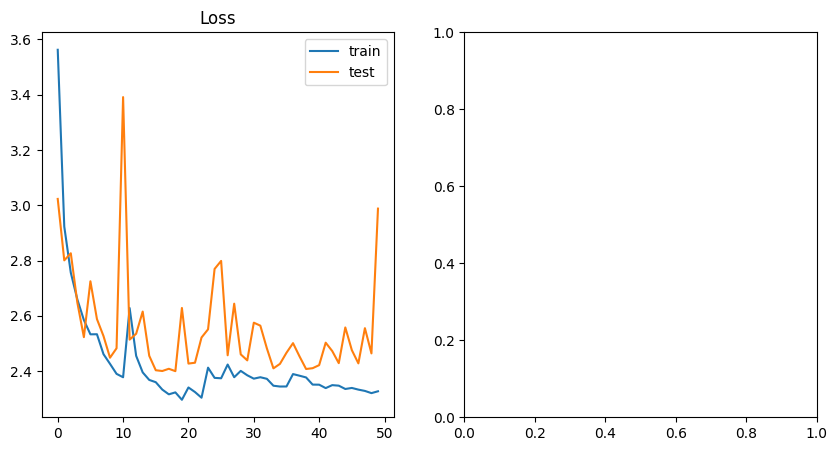

In [10]:
num_classes = len(raw_train_set.class_to_idx)
model = MyCNN2(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, optimizer, criterion, 50, train_loader, test_loader)
torch.save(model.state_dict(), "my_cnn2_50epochs.pth")
# plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="train")
plt.plot(test_loss_list, label="test")
plt.legend()
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label="train")
plt.plot(test_accuracy_list, label="test")
plt.legend()
plt.title("Accuracy")
plt.show()

In [13]:
class MyCNN3(nn.Module):
    def __init__(self, num_classes=50):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

In [14]:
num_classes = len(raw_train_set.class_to_idx)
model = MyCNN3(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, optimizer, criterion, 50, train_loader, test_loader )
torch.save(model.state_dict(), "my_cnn3_50epochs_aug.pth")
# detach to cpu
train_loss_list = [x.cpu().detach().numpy() for x in train_loss_list]
train_accuracy_list = [x.cpu().detach().numpy() for x in train_accuracy_list]
test_loss_list = [x.cpu().detach().numpy() for x in test_loss_list]
test_accuracy_list = [x.cpu().detach().numpy() for x in test_accuracy_list]

# plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="train")
plt.plot(test_loss_list, label="test")
plt.legend()
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label="train")
plt.plot(test_accuracy_list, label="test")
plt.legend()
plt.title("Accuracy")
plt.show()

[1/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 0: TRAINING: epoch loss = 3.43, epoch accuracy = 0.11


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 0: VALIDATION: epoch loss = 3.10, epoch accuracy = 0.18
[2/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 1: TRAINING: epoch loss = 3.15, epoch accuracy = 0.16


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 1: VALIDATION: epoch loss = 2.94, epoch accuracy = 0.22
[3/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 2: TRAINING: epoch loss = 3.02, epoch accuracy = 0.19


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 2: VALIDATION: epoch loss = 2.89, epoch accuracy = 0.23
[4/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 3: TRAINING: epoch loss = 2.93, epoch accuracy = 0.21


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 3: VALIDATION: epoch loss = 2.73, epoch accuracy = 0.28
[5/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 4: TRAINING: epoch loss = 2.84, epoch accuracy = 0.23


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 4: VALIDATION: epoch loss = 2.63, epoch accuracy = 0.29
[6/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 5: TRAINING: epoch loss = 2.77, epoch accuracy = 0.25


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 5: VALIDATION: epoch loss = 2.61, epoch accuracy = 0.31
[7/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 6: TRAINING: epoch loss = 2.71, epoch accuracy = 0.26


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 6: VALIDATION: epoch loss = 2.57, epoch accuracy = 0.31
[8/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 7: TRAINING: epoch loss = 2.66, epoch accuracy = 0.28


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 7: VALIDATION: epoch loss = 2.55, epoch accuracy = 0.31
[9/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 8: TRAINING: epoch loss = 2.61, epoch accuracy = 0.29


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 8: VALIDATION: epoch loss = 2.41, epoch accuracy = 0.36
[10/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 9: TRAINING: epoch loss = 2.57, epoch accuracy = 0.30


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 9: VALIDATION: epoch loss = 2.40, epoch accuracy = 0.36
[11/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 10: TRAINING: epoch loss = 2.53, epoch accuracy = 0.31


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 10: VALIDATION: epoch loss = 2.34, epoch accuracy = 0.38
[12/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 11: TRAINING: epoch loss = 2.49, epoch accuracy = 0.32


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 11: VALIDATION: epoch loss = 2.30, epoch accuracy = 0.38
[13/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 12: TRAINING: epoch loss = 2.46, epoch accuracy = 0.33


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 12: VALIDATION: epoch loss = 2.26, epoch accuracy = 0.39
[14/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 13: TRAINING: epoch loss = 2.43, epoch accuracy = 0.34


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 13: VALIDATION: epoch loss = 2.29, epoch accuracy = 0.39
[15/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 14: TRAINING: epoch loss = 2.40, epoch accuracy = 0.34


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 14: VALIDATION: epoch loss = 2.22, epoch accuracy = 0.41
[16/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 15: TRAINING: epoch loss = 2.37, epoch accuracy = 0.35


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 15: VALIDATION: epoch loss = 2.20, epoch accuracy = 0.41
[17/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 16: TRAINING: epoch loss = 2.35, epoch accuracy = 0.36


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 16: VALIDATION: epoch loss = 2.18, epoch accuracy = 0.42
[18/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 17: TRAINING: epoch loss = 2.32, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 17: VALIDATION: epoch loss = 2.17, epoch accuracy = 0.42
[19/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 18: TRAINING: epoch loss = 2.30, epoch accuracy = 0.37


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 18: VALIDATION: epoch loss = 2.13, epoch accuracy = 0.43
[20/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 19: TRAINING: epoch loss = 2.27, epoch accuracy = 0.38


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 19: VALIDATION: epoch loss = 2.13, epoch accuracy = 0.43
[21/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 20: TRAINING: epoch loss = 2.25, epoch accuracy = 0.38


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 20: VALIDATION: epoch loss = 2.11, epoch accuracy = 0.43
[22/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 21: TRAINING: epoch loss = 2.23, epoch accuracy = 0.39


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 21: VALIDATION: epoch loss = 2.11, epoch accuracy = 0.43
[23/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 22: TRAINING: epoch loss = 2.22, epoch accuracy = 0.39


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 22: VALIDATION: epoch loss = 2.08, epoch accuracy = 0.43
[24/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 23: TRAINING: epoch loss = 2.21, epoch accuracy = 0.40


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 23: VALIDATION: epoch loss = 2.08, epoch accuracy = 0.44
[25/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 24: TRAINING: epoch loss = 2.18, epoch accuracy = 0.40


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 24: VALIDATION: epoch loss = 2.04, epoch accuracy = 0.45
[26/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 25: TRAINING: epoch loss = 2.17, epoch accuracy = 0.41


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 25: VALIDATION: epoch loss = 2.04, epoch accuracy = 0.45
[27/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 26: TRAINING: epoch loss = 2.15, epoch accuracy = 0.41


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 26: VALIDATION: epoch loss = 2.06, epoch accuracy = 0.46
[28/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 27: TRAINING: epoch loss = 2.14, epoch accuracy = 0.41


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 27: VALIDATION: epoch loss = 2.03, epoch accuracy = 0.45
[29/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 28: TRAINING: epoch loss = 2.13, epoch accuracy = 0.42


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 28: VALIDATION: epoch loss = 2.00, epoch accuracy = 0.46
[30/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 29: TRAINING: epoch loss = 2.11, epoch accuracy = 0.42


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 29: VALIDATION: epoch loss = 2.03, epoch accuracy = 0.46
[31/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 30: TRAINING: epoch loss = 2.11, epoch accuracy = 0.42


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 30: VALIDATION: epoch loss = 2.02, epoch accuracy = 0.45
[32/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 31: TRAINING: epoch loss = 2.09, epoch accuracy = 0.43


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 31: VALIDATION: epoch loss = 1.99, epoch accuracy = 0.47
[33/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 32: TRAINING: epoch loss = 2.07, epoch accuracy = 0.43


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 32: VALIDATION: epoch loss = 1.98, epoch accuracy = 0.47
[34/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 33: TRAINING: epoch loss = 2.06, epoch accuracy = 0.43


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 33: VALIDATION: epoch loss = 1.97, epoch accuracy = 0.47
[35/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 34: TRAINING: epoch loss = 2.06, epoch accuracy = 0.44


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 34: VALIDATION: epoch loss = 1.97, epoch accuracy = 0.47
[36/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 35: TRAINING: epoch loss = 2.04, epoch accuracy = 0.44


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 35: VALIDATION: epoch loss = 1.94, epoch accuracy = 0.47
[37/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 36: TRAINING: epoch loss = 2.02, epoch accuracy = 0.45


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 36: VALIDATION: epoch loss = 1.92, epoch accuracy = 0.48
[38/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 37: TRAINING: epoch loss = 2.02, epoch accuracy = 0.44


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 37: VALIDATION: epoch loss = 2.00, epoch accuracy = 0.46
[39/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 38: TRAINING: epoch loss = 2.01, epoch accuracy = 0.45


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 38: VALIDATION: epoch loss = 1.91, epoch accuracy = 0.48
[40/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 39: TRAINING: epoch loss = 2.00, epoch accuracy = 0.45


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 39: VALIDATION: epoch loss = 1.94, epoch accuracy = 0.48
[41/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 40: TRAINING: epoch loss = 1.99, epoch accuracy = 0.46


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 40: VALIDATION: epoch loss = 1.89, epoch accuracy = 0.49
[42/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 41: TRAINING: epoch loss = 1.97, epoch accuracy = 0.46


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 41: VALIDATION: epoch loss = 1.87, epoch accuracy = 0.50
[43/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 42: TRAINING: epoch loss = 1.97, epoch accuracy = 0.46


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 42: VALIDATION: epoch loss = 1.90, epoch accuracy = 0.49
[44/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 43: TRAINING: epoch loss = 1.97, epoch accuracy = 0.46


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 43: VALIDATION: epoch loss = 1.90, epoch accuracy = 0.49
[45/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 44: TRAINING: epoch loss = 1.95, epoch accuracy = 0.47


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 44: VALIDATION: epoch loss = 1.88, epoch accuracy = 0.49
[46/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 45: TRAINING: epoch loss = 1.95, epoch accuracy = 0.47


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 45: VALIDATION: epoch loss = 1.89, epoch accuracy = 0.49
[47/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 46: TRAINING: epoch loss = 1.94, epoch accuracy = 0.47


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 46: VALIDATION: epoch loss = 1.89, epoch accuracy = 0.49
[48/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 47: TRAINING: epoch loss = 1.93, epoch accuracy = 0.47


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 47: VALIDATION: epoch loss = 1.89, epoch accuracy = 0.49
[49/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 48: TRAINING: epoch loss = 1.92, epoch accuracy = 0.47


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 48: VALIDATION: epoch loss = 1.86, epoch accuracy = 0.49
[50/50]


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch 49: TRAINING: epoch loss = 1.92, epoch accuracy = 0.47


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 49: VALIDATION: epoch loss = 1.89, epoch accuracy = 0.49


AttributeError: 'float' object has no attribute 'cpu'

In [ ]:
2+2